In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask
import cftime
import random
import glob
import matplotlib.gridspec as gs
import pint_xarray
import cf_xarray as cfxr

In [2]:
from scipy.stats import ttest_ind

In [3]:
from pint import application_registry as ureg

In [4]:
def roll_longitude(df):
    """
    Rolls the longitude coordinates of a given DataFrame to a range of [0, 360).

    Parameters:
    df (xarray.DataArray): Input DataFrame containing longitude coordinates.

    Returns:
    xarray.DataArray: DataFrame with rolled longitude coordinates.
    """
    # Ensure the longitude coordinates are within the range [0, 360)
    df.coords['xt_ocean'] = (df.coords['xt_ocean']) % 360
    
    # Sort the DataFrame based on the rolled longitude coordinates
    df = df.sortby(df.xt_ocean)
    
    return df


def SSTA(DS):
    """
    Computes the Sea Surface Temperature Anomaly (SSTA) by subtracting the monthly climatology from the input dataset.

    Parameters:
    DS (xarray.Dataset): Input dataset containing SST values.

    Returns:
    xarray.Dataset: Dataset with Sea Surface Temperature Anomaly.
    """
    clim = DS.groupby('time.month').mean('time')
    ssta = DS.groupby('time.month') - clim
    return ssta

def NINO34(DS):
    """
    Calculates the NINO3.4 index representing the average sea surface temperature anomaly in the NINO3.4 region.

    Parameters:
    DS (xarray.Dataset): Input dataset containing SST values.

    Returns:
    xarray.DataArray: NINO3.4 index calculated from the dataset.
    """
    return SSTA(DS).sel(yt_ocean=slice(-5, 5), xt_ocean=slice(190, 240)).mean(['yt_ocean', 'xt_ocean'])

def IOBM(DS):
    """
    Computes the Indian Ocean Basin Mode (IOBM) by averaging the sea surface temperature anomaly in a specified region.

    Parameters:
    DS (xarray.Dataset): Input dataset containing SST values.

    Returns:
    xarray.DataArray: IOBM calculated from the dataset.
    """
    return SSTA(DS).sel(yt_ocean=slice(-20, 20), xt_ocean=slice(40, 100)).mean(['yt_ocean', 'xt_ocean'])

def DMI(DS):
    """
    Calculates the Dipole Mode Index (DMI) representing the temperature gradient between Western and Southeastern Indian Ocean regions.

    Parameters:
    DS (xarray.Dataset): Input dataset containing SST values.

    Returns:
    xarray.DataArray: DMI calculated from the dataset.
    """
    WTIO = SSTA(DS).sel(yt_ocean=slice(-10, 10), xt_ocean=slice(50, 70)).mean(['yt_ocean', 'xt_ocean'])
    SETIO = SSTA(DS).sel(yt_ocean=slice(-10, 0), xt_ocean=slice(90, 110)).mean(['yt_ocean', 'xt_ocean'])
    return (WTIO - SETIO).drop('month')

def EIO(DS):
    """
    Calculates the Eastern Indian Ocean (EIO) index representing the average sea surface temperature anomaly in the Eastern Indian Ocean region.

    Parameters:
    DS (xarray.Dataset): Input dataset containing SST values.

    Returns:
    xarray.DataArray: EIO index calculated from the dataset.
    """
    SETIO = SSTA(DS).sel(yt_ocean=slice(-10, 0), xt_ocean=slice(90, 110)).mean(['yt_ocean', 'xt_ocean'])
    return SETIO.drop('month')

def EIO_1(DS):
    """
    Calculates the average sea surface temperature anomaly in the Eastern Indian Ocean region without monthly averaging.

    Parameters:
    DS (xarray.Dataset): Input dataset containing SST values.

    Returns:
    xarray.DataArray: EIO index calculated without monthly averaging.
    """
    SETIO = DS.sel(yt_ocean=slice(-10, 0), xt_ocean=slice(90, 110)).mean(['yt_ocean', 'xt_ocean'])
    return SETIO

def WIO(DS):
    """
    Calculates the Western Indian Ocean (WIO) index representing the average sea surface temperature anomaly in the Western Indian Ocean region.

    Parameters:
    DS (xarray.Dataset): Input dataset containing SST values.

    Returns:
    xarray.DataArray: WIO index calculated from the dataset.
    """
    WTIO = SSTA(DS).sel(yt_ocean=slice(-10, 10), xt_ocean=slice(50, 70)).mean(['yt_ocean', 'xt_ocean'])
    return WTIO.drop('month')

def WIO_1(DS):
    """
    Calculates the average sea surface temperature anomaly in the Western Indian Ocean region without monthly averaging.

    Parameters:
    DS (xarray.Dataset): Input dataset containing SST values.

    Returns:
    xarray.DataArray: WIO index calculated without monthly averaging.
    """
    WTIO = DS.sel(yt_ocean=slice(-10, 10), xt_ocean=slice(50, 70)).mean(['yt_ocean', 'xt_ocean'])
    return WTIO

def IOD_events(ds):
    """
    Identifies Indian Ocean Dipole (IOD) events based on the Dipole Mode Index (DMI) timeseries within specific seasons.

    Parameters:
    ds (xarray.Dataset): Input dataset containing the Dipole Mode Index (DMI) values.

    Returns:
    tuple: Two DataArrays representing negative (nIOD) and positive (pIOD) IOD events.
    """
    # Get the DMI timeseries in seasons starting from DJF, MAM, etc.
    QS = DMI(ds).resample(time='QS-DEC').mean(dim="time")
    
    # Select SON seasons into a timeseries
    SON = QS.groupby('time.season')["SON"]
    
    # Use quantiles to select all events and create DataArrays of nIOD and pIOD event values
    lower, upper = SON.quantile([0.2, 0.8])
    nIOD = SON.where(SON <= lower.values).dropna(dim="time")
    pIOD = SON.where(SON > upper.values).dropna(dim="time")
    
    return nIOD, pIOD

def get_IOD_times(ds_sst, ds_var=None):
    """
    Subsets a variable based on the positive (pIOD) and negative (nIOD) Indian Ocean Dipole events derived from Sea Surface Temperature (SST) dataset.

    Parameters:
    ds_sst (xarray.Dataset): Sea Surface Temperature dataset containing IOD events.
    ds_var (xarray.Dataset, optional): Variable dataset to be subset based on IOD events. Defaults to None.

    Returns:
    tuple: Two subsets of the variable dataset corresponding to positive (subset_ds_pos) and negative (subset_ds_neg) IOD events.
    """
    # Extract positive and negative IOD events based on SST dataset
    nIOD, pIOD = IOD_events(ds_sst)
    
    # Calculate the mean year for nIOD and pIOD
    nIOD = nIOD.groupby("time.year").mean("time").year
    pIOD = pIOD.groupby("time.year").mean("time").year
    
    # If ds_var is not provided, use ds_sst
    if ds_var is None:
        ds_var = ds_sst
    
    # Resample ds_var by season and group by year
    ds_var = ds_var.resample(time='QS-DEC').mean(dim="time").groupby("time.year")
    
    # Initialize empty lists to store subsets
    pos_list = []
    neg_list = []
    
    # Loop through each year group in ds_var and subset based on specific years in nIOD and pIOD
    for year, group in ds_var:
        if year in pIOD:
            pos_subset = group
            pos_list.append(pos_subset)
        elif year in nIOD:
            neg_subset = group
            neg_list.append(neg_subset)
        else:
            pass
    
    # Concatenate subsets into a single DataArray
    subset_ds_pos = xr.concat(pos_list, dim='time')
    subset_ds_neg = xr.concat(neg_list, dim='time')
    
    return subset_ds_pos, subset_ds_neg

def calc_seasonal_TS(ds, season):
    """
    Calculates seasonal mean temperature or other variable from the given dataset for a specified season.

    Parameters:
    ds (xarray.Dataset): Input dataset containing the variable of interest.
    season (str): Season to calculate the mean for (e.g., 'DJF', 'MAM', 'JJA', 'SON').

    Returns:
    xarray.Dataset: Seasonal mean dataset for the specified season.
    """
    # Resample dataset by season and calculate mean for each year
    Seas = ds.resample(time='QS-DEC').mean(dim="time").groupby("time.season")
    
    # Extract the dataset for the specified season and calculate the mean for each year
    seasonal_ds = Seas[season].groupby('time.year').mean("time")
    
    return seasonal_ds

def ENLN_events(ds):
    """
    Identifies El Niño (EN) and La Niña (LN) events based on the Nino3.4 index timeseries within specific seasons.

    Parameters:
    ds (xarray.Dataset): Input dataset containing the Nino3.4 index values.

    Returns:
    tuple: Two DataArrays representing El Niño (EN) and La Niña (LN) events.
    """
    # Get the Nino34 timeseries in seasons starting from DJF, MAM, etc.
    QS = NINO34(ds).resample(time='QS-DEC').mean(dim="time")
    
    # Select DJF seasons into a timeseries
    DJF = QS.groupby('time.season')["DJF"]
    
    # Use quantiles to select all events and create DataArrays of EN and LN event values
    lower, upper = DJF.quantile([0.2, 0.8])
    LN = DJF.where(DJF <= lower.values).dropna(dim="time")
    EN = DJF.where(DJF > upper.values).dropna(dim="time")
    
    return LN, EN

def get_ENLN_times(ds_sst, ds_var=None):
    """
    Subsets a variable based on the positive (EN) and negative (LN) El Niño/La Niña events derived from Sea Surface Temperature (SST) dataset.

    Parameters:
    ds_sst (xarray.Dataset): Sea Surface Temperature dataset containing Nino3.4 index events.
    ds_var (xarray.Dataset, optional): Variable dataset to be subset based on ENLN events. Defaults to None.

    Returns:
    tuple: Two subsets of the variable dataset corresponding to positive (subset_ds_pos) and negative (subset_ds_neg) ENLN events.
    """
    # Extract positive (EN) and negative (LN) ENLN events based on SST dataset
    LN, EN = ENLN_events(ds_sst)
    
    # Calculate the mean year for LN and EN
    LN = LN.groupby("time.year").mean("time").year
    EN = EN.groupby("time.year").mean("time").year
    
    # If ds_var is not provided, use ds_sst
    if ds_var is None:
        ds_var = ds_sst
    
    # Resample ds_var by season and group by year
    ds_var = ds_var.resample(time='QS-DEC').mean(dim="time").groupby("time.year")
    
    # Initialize empty lists to store subsets
    pos_list = []
    neg_list = []
    
    # Loop through each year group in ds_var and subset based on specific years in LN and EN
    for year, group in ds_var:
        if year in EN:
            pos_subset = group
            pos_list.append(pos_subset)
        elif year in LN:
            neg_subset = group
            neg_list.append(neg_subset)
        else:
            pass
    
    # Concatenate subsets into a single DataArray
    subset_ds_pos = xr.concat(pos_list, dim='time')
    subset_ds_neg = xr.concat(neg_list, dim='time')
    
    return subset_ds_pos, subset_ds_neg


In [5]:
data_dir = "/g/data/e14/sm2435/Exps_ACCESS_initial/"

In [44]:
ctrl_z20 = xr.open_dataset(data_dir+"ctrl_z20.nc", use_cftime=True, chunks= {"time":240}).z20

In [7]:
ctrl_z20 = ctrl_z20.compute()

In [8]:
VC_z20 = xr.open_dataset(data_dir+"Var_pace_z20.nc", use_cftime=True, chunks= {"time":240})

In [9]:
OC_z20 = xr.open_dataset(data_dir+"obs_pace_z20.nc", use_cftime=True, chunks= {"time":240})

In [10]:
MC_z20 = xr.open_dataset(data_dir+"mod_pace_z20.nc", use_cftime=True, chunks= {"time":240})

In [11]:
OC_z20 = OC_z20.compute()
MC_z20 = MC_z20.compute()
VC_z20 = VC_z20.compute()

In [12]:
ctrl_sst = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/ctrl_sst.nc",  use_cftime=True, chunks= {"time":240})
ctrl_sst = ctrl_sst.sst.compute()

In [13]:
ctrl_sst = roll_longitude(ctrl_sst)

In [14]:
VC_sst = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/VAR_PACE_sst.nc",  use_cftime=True, chunks= {"time":240})
VC_sst = VC_sst.sst.compute()

In [15]:
VC_sst = roll_longitude(VC_sst)

In [16]:
OC_sst = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/OC_sst.nc",  use_cftime=True, chunks= {"time":240})
OC_sst = OC_sst.sst.compute()

In [17]:
OC_sst = roll_longitude(OC_sst)

In [18]:
MC_sst = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/MC_sst.nc",  use_cftime=True, chunks= {"time":240})
MC_sst = MC_sst.sst.compute()

In [19]:
MC_sst = roll_longitude(MC_sst)

In [20]:
#load in SST restorign climatology

In [21]:
Hadclim = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/HadISST_Climatology.nc", decode_times = False)

In [22]:
Hadclim = Hadclim.rename({"TIME":"month", "GRID_Y_T":"yt_ocean", "GRID_X_T":"xt_ocean"})

In [23]:
Hadclim = Hadclim["temp"].drop("DEPTH1_1")[0]

In [24]:
Hadclim["month"] = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]

In [25]:
Hadclim = roll_longitude(Hadclim)

In [26]:
#now to calculate SST bias and plot

In [33]:
def plot_bias_sig_annual(ctrl, exp, temp_scale=2):
    ctrl_mn = ctrl.sel(month = slice(9,11)).mean('month')
    exp_mn = exp.groupby("time.season")["SON"].mean("time")
    # Now calculate significance for annual component
    #dims = ('latitude', 'longitude')
    #t_stat, p_value = ttest_ind(exp, ctrl)
    #t_stat_ds = xr.DataArray(t_stat, dims=dims, coords={dim: exp.coords[dim] for dim in dims})
    #p_value_ds = xr.DataArray(p_value, dims=dims, coords={dim: exp.coords[dim] for dim in dims})
    #sig_p = p_value_ds.where(p_value_ds < 0.05, np.nan)
    
    # Now plot figure
    plt.figure(figsize=(12, 4))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

    # Set extent for longitude and latitude if provided
    ax.set_extent([30, 290, -30, 30], crs=ccrs.PlateCarree())

    bias = (exp_mn - ctrl_mn)
    bias.plot.contourf(ax=ax, vmin=-1*temp_scale, vmax=temp_scale, cmap="RdBu_r", levels=10, extend='both',
                       transform=ccrs.PlateCarree(), cbar_kwargs=dict(label='temp bias oC'))

    ax.coastlines(color='k')
    ax.axhline(y=-15, color='black', linestyle='--', linewidth=1)  # 15S
    ax.axhline(y=15, color='black', linestyle='--', linewidth=1)
    ax.gridlines()
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
   
    # Plot significance
    #ax.contourf(sig_p.longitude, sig_p.latitude, sig_p, levels=[0, 0.05],
    #            hatches=['///'], alpha=0.0, add_colorbar=False, transform=ccrs.PlateCarree())
    
    return


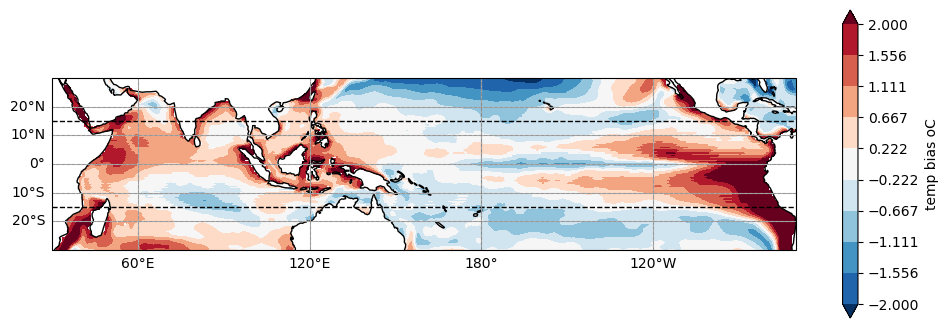

In [34]:
plot_bias_sig_annual(Hadclim, ctrl_sst)

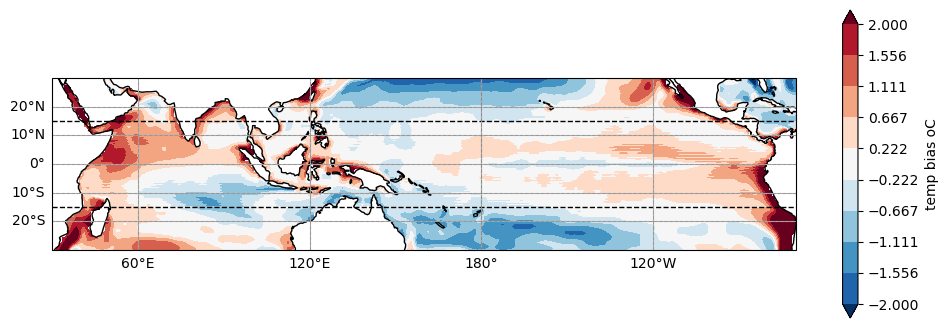

In [37]:
plot_bias_sig_annual(Hadclim, OC_sst)

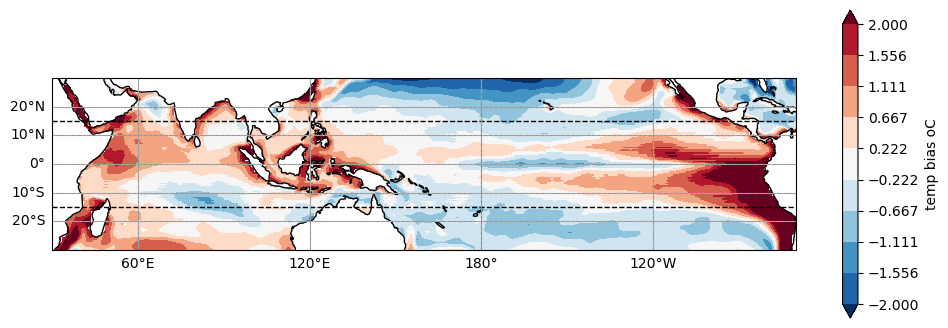

In [38]:
plot_bias_sig_annual(Hadclim, MC_sst)

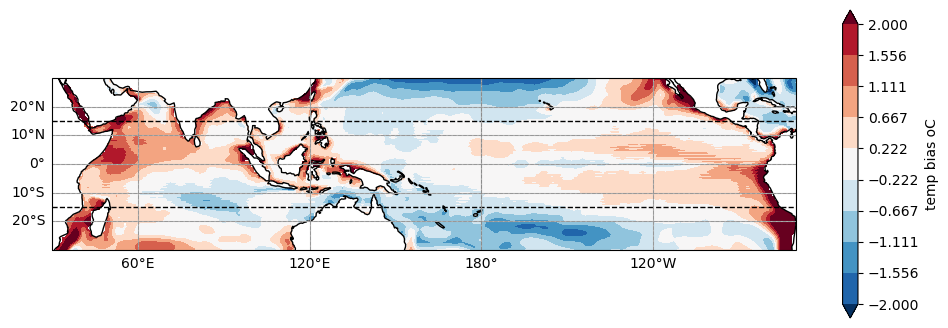

In [39]:
plot_bias_sig_annual(Hadclim, VC_sst)

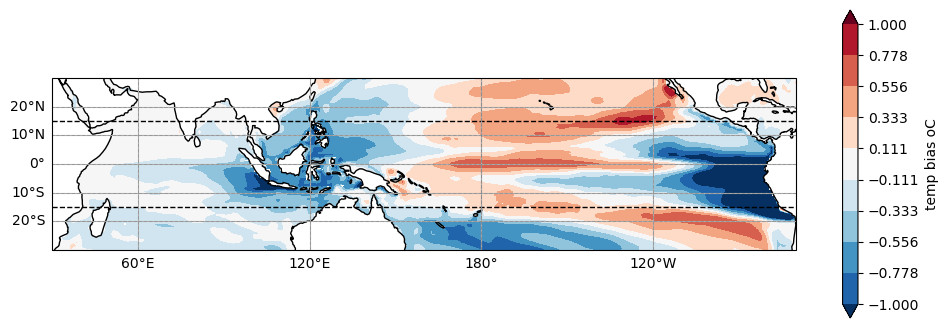

In [35]:
plot_bias_sig_annual(ctrl_sst, OC_sst, temp_scale = 1)

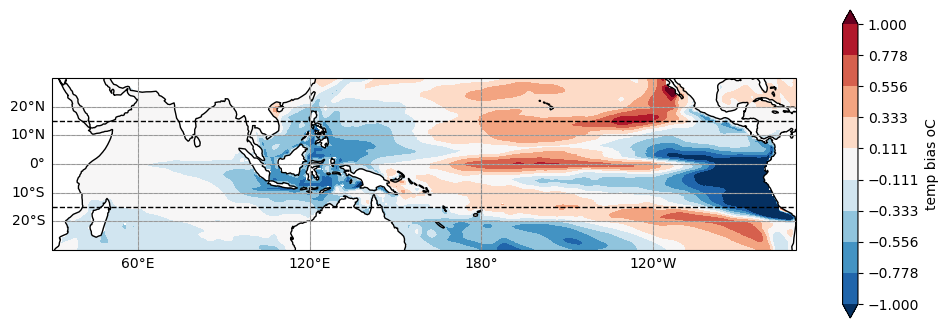

In [36]:
plot_bias_sig_annual(ctrl_sst, VC_sst, temp_scale = 1)

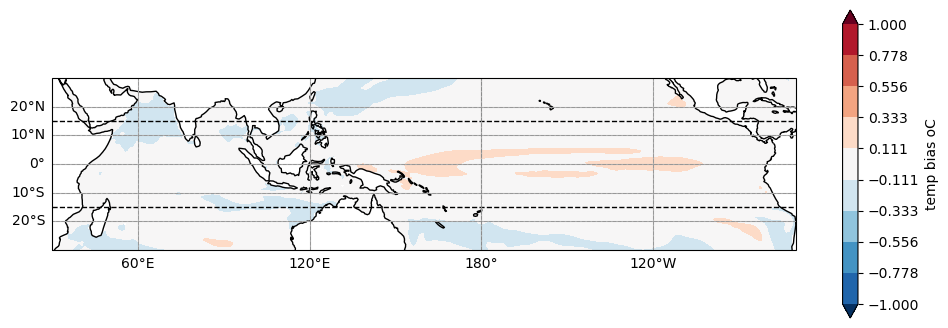

In [37]:
plot_bias_sig_annual(ctrl_sst, MC_sst, temp_scale = 1)

In [41]:
def plot_bias_sig_annual_z20(ctrl, exp, temp_scale=20):
    ctrl_mn = ctrl.groupby("time.season")["SON"].mean('time')
    exp_mn = exp.groupby("time.season")["SON"].mean("time")
    # Now calculate significance for annual component
    #dims = ('latitude', 'longitude')
    #t_stat, p_value = ttest_ind(exp, ctrl)
    #t_stat_ds = xr.DataArray(t_stat, dims=dims, coords={dim: exp.coords[dim] for dim in dims})
    #p_value_ds = xr.DataArray(p_value, dims=dims, coords={dim: exp.coords[dim] for dim in dims})
    #sig_p = p_value_ds.where(p_value_ds < 0.05, np.nan)
    
    # Now plot figure
    plt.figure(figsize=(12, 4))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

    # Set extent for longitude and latitude if provided
    ax.set_extent([30, 290, -30, 30], crs=ccrs.PlateCarree())

    bias = (exp_mn - ctrl_mn)
    bias.plot.contourf(ax=ax, vmin=-1*temp_scale, vmax=temp_scale, cmap="RdBu_r", levels=10, extend='both',
                       transform=ccrs.PlateCarree(), cbar_kwargs=dict(label='z20 depth bias m'))

    ax.coastlines(color='k')
    ax.axhline(y=-15, color='black', linestyle='--', linewidth=1)  # 15S
    ax.axhline(y=15, color='black', linestyle='--', linewidth=1)
    ax.gridlines()
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
   
    # Plot significance
    #ax.contourf(sig_p.longitude, sig_p.latitude, sig_p, levels=[0, 0.05],
    #            hatches=['///'], alpha=0.0, add_colorbar=False, transform=ccrs.PlateCarree())
    
    return


AttributeError: 'DatasetPlotAccessor' object has no attribute 'contourf'

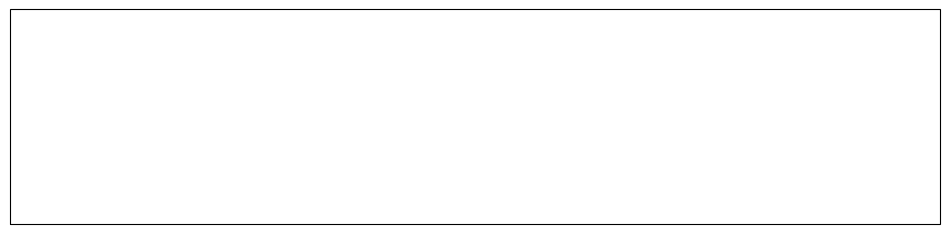

In [42]:
plot_bias_sig_annual_z20(ctrl_z20, VC_z20)

In [43]:
ctrl_z20

<xarray.Dataset>
Dimensions:   (xt_ocean: 360, yt_ocean: 300, time: 2424)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
  * time      (time) object 0950-01-16 12:00:00 ... 1151-12-16 12:00:00
    geolat_t  (yt_ocean, xt_ocean) float32 -77.88 -77.88 -77.88 ... 65.63 65.21
    geolon_t  (yt_ocean, xt_ocean) float32 -279.5 -278.5 -277.5 ... 79.97 79.99
Data variables:
    z20       (time, yt_ocean, xt_ocean) float64 nan nan nan nan ... nan nan nan